In [20]:
import math


##---- 
#    All these computations are done in the plane, the sites are also called nodes
##-------------------------
##looks up for all possible intersections in the beach line current status and adds them to the stack of events

def search_inter():
  global events
  aux_l=status['beach']
  circle_ev=[ev for ev in events if 'y' in ev]
  for i in range(len(aux_l)-2):
    if aux_l[i:i+3] not in [ev['ids'] for ev in circle_ev]:
    #checks if there are three consecutive different arcs in the state
      if len(set(aux_l[i:i+3]))==3:
        p1,p2,p3=ind_p[aux_l[i]],ind_p[aux_l[i+1]],ind_p[aux_l[i+2]]
        if cross(p1,p2,p3)!= 0:
          ctr,rad=centr_circle(p1,p2,p3)
          #if the bottom of the intersection circle is below of the current sweep line inserts this new event
          if ctr[1] - rad <= status['y']:
            insert_ev(aux_l[i],aux_l[i+1],aux_l[i+2],ctr,rad)
#cross product between the vector p2 -> p1 and p2 -> p3 for points 
cross = lambda p1, p2, p3: (p1[0] - p2[0]) * (p3[1] - p2[1]) - (p1[1] - p2[1]) * (p3[0] - p2[0])
#gives the y coordinate for x lying in the parabola with a focus at p   and a dicrectrix at y=l
parabola= lambda x,p,l: (p[0]**2 - l**2 - 2 * p[0] * x + x**2 + p[1]**2) / (2 * (p[1] - l))

#adds the midpoint to the vertices of the Voronoi diagram given two indices of the corresponding nodes
def add_bisect(i1,i2):
  p1x,p1y=ind_p[i1]
  p2x,p2y=ind_p[i2]
  vor_vertices[(i1,i2)]=((p1x+p2x)/2,(p1y+p2y)/2)

##gives the id of the arc in the state directly above the point pto, retuns -1 if there's none
def id_arc_above(pto):
  ind_min=-1
  minn=10000
  l=status['y']
  for p in status['beach']:
    val=parabola(pto[0],ind_p[p],l)
    if val < minn:
      ind_min=p
      minn=val
  return ind_min
#procesa los eventos
#finds the centr of the circle defined by three points, caveat, no two points can have the same y coordinate
def bisector_2p(p1, p2):
    p1x, p1y = p1
    p2x, p2y = p2
    m1 = ((p2x - p1x)/(p1y - p2y) )
    b1 = (p1y + p2y) / 2 - m1 * (p1x + p2x) / 2
    return (m1, b1)

def int_2lines(m1, b1, m2, b2):
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return (x, y)

def centr_circle(p1, p2, p3):
    if p1[1] != p2[1] != p3[1]:
       m1, b1 = bisector_2p(p1, p2)
       m2, b2 = bisector_2p(p2, p3)
    elif p2[1] != p1[1] != p3[1]:
       m1, b1 = bisector_2p(p1, p2)
       m2, b2 = bisector_2p(p1, p3)
    else:
       m1, b1 = bisector_2p(p3, p2)
       m2, b2 = bisector_2p(p1, p3)
             
    pt=int_2lines(m1, b1, m2, b2)
    rad=math.sqrt((p1[0]-pt[0])**2 + (p1[1]-pt[1])**2)
    return pt,rad
#adiciona el circle event manteniendo el orden
def insert_ev(i1,i2,i3,ctr,rad):
  global events
  new_ev={'ids':[i1,i2,i3],'coord':ctr, 'y':ctr[1]-rad}
  if len(events)==0:
     events=[new_ev]
  else:
    y_top=events[-1]['y'] if 'y' in events[-1] else events[-1][1]
    x_top=events[-1]['coord'][0] if 'coord' in events[-1] else events[-1][0]
    if y_top <ctr[1]-rad or (y_top==ctr[1]-rad and x_top>ctr[0]):
        events.append(new_ev)
    else:
        for i in range(len(events)):
            event=events[i]
            event_y = event['y'] if 'y' in event else event[1]
            event_x = event['coord'][0] if 'coord' in event else event[0]
            if event_y>ctr[1]-rad or (event_y==ctr[1]-rad and event_x<ctr[0]):
                events=events[:i] + [new_ev]+ events[i:]



points=[(3, 6), (10, 5), (4, 3), (8, 9), (9, 3), (1, 8), (4, 1)]
## En el estado se mantiene el actual orden de los arcos
## 
#funcion que da el valor en y  correspondiente a x en la parabola dada por la linea a altura l
# punto p
def elimina_arcos_fuera(y):
   global bd_max_x
   global bd_min_x
   while len(status['beach']) >1 and parabola(bd_min_x ,ind_p[status['beach'][0]],y) > parabola(bd_min_x ,ind_p[status['beach'][1]],y):
      status['beach']=status['beach'][1:]
   while len(status['beach']) >1 and parabola(bd_max_x ,ind_p[status['beach'][-1]],y) > parabola(bd_max_x ,ind_p[status['beach'][-2]],y):
      status['beach']=status['beach'][:-1]   

#define los bordes en que esta el diagrama
bd_max_x=max([p[0] for p in points])
bd_min_x=min([p[0] for p in points])
bd_max_y=max([p[1] for p in points])
bd_min_y=min([p[1] for p in points])
#en el estado se guarda en beach el orden de los segmentos de izquierda a derecha
#en el beach line, la actual altura y de la linea de barrido
status={'beach':[]}
#diccionario que como llave tiene los indices de los nodos involucrados y como valor las coordenadas
vor_vertices={}
events=sorted(points, key=lambda x: (x[1],-x[0]))
#shallow copy sirve como diccionario de indice -> punto, indice segun orden como eventos
ind_p=events[:]



while len(events) >0:
  to_process=events.pop()

  #caso en que el evento a procesar sea un nuevo nodo
  if to_process in ind_p:
    status['y']=to_process[1] 
    elimina_arcos_fuera(status['y'])
    print('y cambia a ',status['y'],' con ', to_process)
    #indice del arco sobre el nodo
    ind=id_arc_above(to_process)
    i_2proc=ind_p.index(to_process)
    if ind==-1:
      status['beach']=[i_2proc]
    else:
      aux_i=status['beach'].index(ind)
      add_bisect(ind,i_2proc)
      status['beach']=status['beach'][:aux_i +1]+[i_2proc]+status['beach'][aux_i:]
      print(' status cam ',[ind_p[i] for i in status['beach']])
      search_inter()
  #caso en que el evento a procesar sea un circle event
  else:
    status['y']=to_process['y']
    print(' procesando circle ',to_process)
    ids=to_process['ids']
    beach_st=status['beach']
    #elimina el elemento de la mitad en la secuencia especifica 
    for i in range(len(beach_st) - 2 ):
        if beach_st[i:i + 3] == ids:
          k=i
          status['beach']=beach_st[:i+1]+beach_st[i+2:]
          print('status cambia a ',[ind_p[i] for i in status['beach']])
          break

    add_bisect(status['beach'][k],status['beach'][k+1])
    search_inter()
    events=[e for e in events if not ('ids' in e and ids[1] in e['ids'])]
    vor_vertices[(ids[0],ids[1],ids[2])]=to_process['coord']


y cambia a  9  con  (8, 9)
y cambia a  8  con  (1, 8)
 status cam  [(8, 9), (1, 8), (8, 9)]
y cambia a  6  con  (3, 6)
 status cam  [(1, 8), (3, 6), (1, 8), (8, 9)]
 procesando circle  {'ids': [4, 5, 6], 'coord': (4.375, 9.375), 'y': 5.730655065721687}
status cambia a  [(1, 8), (3, 6), (8, 9)]
y cambia a  5  con  (10, 5)
 status cam  [(1, 8), (3, 6), (8, 9), (10, 5), (8, 9)]
y cambia a  3  con  (4, 3)
 status cam  [(3, 6), (4, 3), (3, 6), (8, 9), (10, 5)]


ZeroDivisionError: division by zero

In [105]:
vor_vertices

{(6, 5): (4.5, 8.5),
 (5, 4): (2.0, 7.0),
 (4, 6): (5.5, 7.5),
 (4, 5, 6): (4.375, 9.375),
 (6, 3): (9.0, 7.0),
 (3, 2): (9.5, 4.1),
 (4, 1): (3.5, 4.5),
 (4, 3): (6.5, 5.5),
 (4, 6, 3): (6.538461538461538, 5.76923076923077),
 (4, 2): (6.0, 4.6),
 (4, 3, 2): (6.53529411764706, 5.747058823529414),
 (1, 2): (6.5, 3.1),
 (1, 4, 2): (6.405263157894738, 5.468421052631579),
 (1, 0): (4.0, 2.0),
 (0, 2): (6.5, 2.1),
 (0, 1, 2): (6.544, 2.0)}

In [15]:
#finds the centr of the circle defined by three points, caveat, no two points can have the same y coordinate
def bisector_2p(p1, p2):
    p1x, p1y = p1
    p2x, p2y = p2
    m1 = ((p2x - p1x)/(p1y - p2y) )
    b1 = (p1y + p2y) / 2 - m1 * (p1x + p2x) / 2
    return (m1, b1)

def int_2lines(m1, b1, m2, b2):
    x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    return (x, y)

def centr_circle(p1, p2, p3):
    m1, b1 = bisector_2p(p1, p2)
    m2, b2 = bisector_2p(p2, p3)
    pt=int_2lines(m1, b1, m2, b2)
    rad=math.sqrt((p1[0]-pt[0])**2 + (p1[1]-pt[1])**2)
    return pt,rad
#adiciona el circle event manteniendo el orden
def insert_ev(i1,i2,i3,ctr,rad):
  global events
  new_ev={'ids':[i1,i2,i3],'coord':ctr, 'y':ctr[1]-rad}
  if len(events)==0:
     events=[new_ev]
  else:
    y_top=events[-1]['y'] if 'y' in events[-1] else events[-1][1]
    x_top=events[-1]['coord'][0] if 'coord' in events[-1] else events[-1][0]
    if y_top <ctr[1]-rad or (y_top==ctr[1]-rad and x_top>ctr[0]):
        events.append(new_ev)
    else:
        for i in range(len(events)):
            event=events[i]
            event_y = event['y'] if 'y' in event else event[1]
            event_x = event['coord'][0] if 'coord' in event else event[0]
            if event_y>ctr[1]-rad or (event_y==ctr[1]-rad and event_x<ctr[0]):
                events=events[:i] + [new_ev]+ events[i:]
              


In [30]:
points=[(1.4, 2), (2.4, 3),(2,1.5)]
events=sorted(points, key=lambda x: (x[1],-x[0]))
def insert_ev(i1,i2,i3,ctr,rad):
  global events
  new_ev={'ids':[i1,i2,i3],'coord':ctr, 'y':ctr[1]-rad}
  if len(events)==0:
     events=[new_ev]
  else:
    for i in range(len(events)):
        event=events[i]
        event_y = event['y'] if 'y' in event else event[1]
        if event_y>ctr[1]-rad:
           events=events[:i] + [new_ev]+ events[i:]
           break
        elif event_y==ctr[1]-rad:
           event_x = event['coord'][0] if 'coord' in event else event[0]
           if event_x <ctr[0]:
              events=events[:i] + [new_ev]+ events[i:]
              break


In [59]:
events=[(2, 1.5),
 (1.4, 2),
 {'ids': [1, 2, 3], 'coord': (1, 4), 'y': 2},
 {'ids': [1, 1, 1], 'coord': (-0.2, 4), 'y': 2.5},
 (2.4, 3),
 {'ids': [1, 1, 1], 'coord': (0.2, 3.5), 'y': 3.5},
 {'ids': [1, 1, 3], 'coord': (0, 4), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-0.2, 3.5), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-1, 3.5), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-4.0, 3.5), 'y': 3.5}]
events=[e for e in events if not ('ids' in e and 3 in e['ids'])]
events     

[(2, 1.5),
 (1.4, 2),
 {'ids': [1, 1, 1], 'coord': (-0.2, 4), 'y': 2.5},
 (2.4, 3),
 {'ids': [1, 1, 1], 'coord': (0.2, 3.5), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-0.2, 3.5), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-1, 3.5), 'y': 3.5},
 {'ids': [1, 1, 1], 'coord': (-4.0, 3.5), 'y': 3.5}]

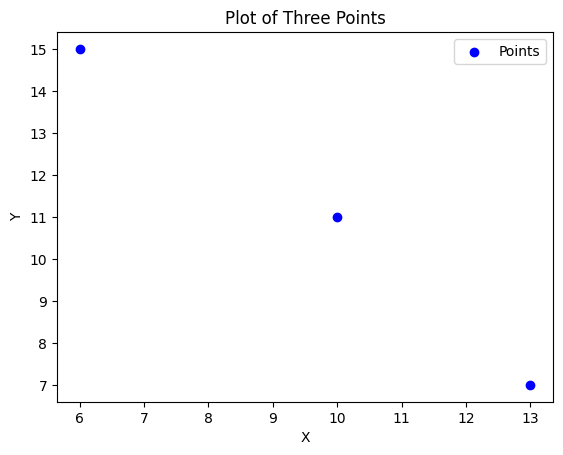

In [12]:

import matplotlib.pyplot as plt
import random

points = [(random.randint(1,15), random.randint(1,15)) for _ in range(3)]


# Extract x and y coordinates from the points
x_coords, y_coords = zip(*points)

# Plot the points
plt.scatter(x_coords, y_coords, color='blue', label='Points')

# Add labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Plot of Three Points')

# Add a legend
plt.legend()
def cross(p1,p2,p3):
    'returns the cross prod between the vector from p2-p1 and p3-p2'
    return (p1[0]-p2[0])*(p3[1]-p2[1])-(p1[1]-p2[1])*(p3[0]-p2[0])
